In [5]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LassoCV

In [3]:
energy = pd.read_csv(r'C:\Users\mike1\Documents\Thinkful\energy-usage-2010.csv', low_memory = False)
energy.head()

,COMMUNITY AREA NAME,CENSUS BLOCK,BUILDING TYPE,BUILDING_SUBTYPE,KWH JANUARY 2010,KWH FEBRUARY 2010,KWH MARCH 2010,KWH APRIL 2010,KWH MAY 2010,KWH JUNE 2010,...,TOTAL POPULATION,TOTAL UNITS,AVERAGE STORIES,AVERAGE BUILDING AGE,AVERAGE HOUSESIZE,OCCUPIED UNITS,OCCUPIED UNITS PERCENTAGE,RENTER-OCCUPIED HOUSING UNITS,RENTER-OCCUPIED HOUSING PERCENTAGE,OCCUPIED HOUSING UNITS
0,Archer Heights,1.703157e+14,Residential,Multi < 7,NaN,NaN,NaN,NaN,NaN,NaN,...,89.0,24.0,2.0,71.33,3.87,23.0,0.9582,9.0,0.3910,23.0
1,Ashburn,1.703170e+14,Residential,Multi 7+,7334.0,7741.0,4214.0,4284.0,2518.0,4273.0,...,112.0,67.0,2.0,41.00,1.81,62.0,0.9254,50.0,0.8059,62.0
2,Auburn Gresham,1.703171e+14,Commercial,Multi < 7,NaN,NaN,NaN,NaN,NaN,NaN,...,102.0,48.0,3.0,86.00,3.00,34.0,0.7082,23.0,0.6759,34.0
3,Austin,1.703125e+14,Commercial,Multi < 7,NaN,NaN,NaN,NaN,NaN,NaN,...,121.0,56.0,2.0,84.00,2.95,41.0,0.7321,32.0,0.7800,41.0
4,Austin,1.703125e+14,Commercial,Multi < 7,NaN,NaN,NaN,NaN,NaN,NaN,...,62.0,23.0,2.0,85.00,3.26,19.0,0.8261,11.0,0.5790,19.0


In [101]:
energy = energy.sample(n = 10000)
energy.dropna()

energy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 23013 to 33510
Data columns (total 75 columns):
COMMUNITY AREA NAME                    10000 non-null object
CENSUS BLOCK                           9988 non-null float64
BUILDING TYPE                          10000 non-null object
BUILDING_SUBTYPE                       9988 non-null object
KWH JANUARY 2010                       9870 non-null float64
KWH FEBRUARY 2010                      9870 non-null float64
KWH MARCH 2010                         9870 non-null float64
KWH APRIL 2010                         9870 non-null float64
KWH MAY 2010                           9870 non-null float64
KWH JUNE 2010                          9870 non-null float64
KWH JULY 2010                          9870 non-null float64
KWH AUGUST 2010                        9870 non-null float64
KWH SEPTEMBER 2010                     9870 non-null float64
KWH OCTOBER 2010                       9870 non-null float64
KWH NOVEMBER 2010                 

In [100]:
#clean up building type and get dummies
energy['BUILDING TYPE'].fillna('Residential', inplace = True)
energy['BUILDING TYPE'].replace('Industrial', 'Commercial', inplace = True)
energy['DUMMIES BUILDING TYPE'] = pd.get_dummies(energy['BUILDING TYPE'], drop_first=True)
energy['BUILDING TYPE'].unique()

array(['Residential', 'Commercial'], dtype=object)

In [112]:
#clean up feature variables
energy.loc[:, 'TOTAL KWH'] = energy.loc[:, 'TOTAL KWH'].fillna(energy.loc[:, 'TOTAL KWH'].mean())
energy.loc[:, 'AVERAGE HOUSESIZE'] = energy.loc[:, 'AVERAGE HOUSESIZE'].fillna(energy.loc[:, 'AVERAGE HOUSESIZE'].mean())
energy.loc[:, 'TOTAL THERMS'] = energy.loc[:, 'TOTAL THERMS'].fillna(energy.loc[:, 'TOTAL THERMS'].mean())
energy.loc[:, 'KWH TOTAL SQFT'] = energy.loc[:, 'KWH TOTAL SQFT'].fillna(energy.loc[:, 'KWH TOTAL SQFT'].mean())
energy.loc[:, 'OCCUPIED UNITS'] = energy.loc[:, 'OCCUPIED UNITS'].fillna(energy.loc[:, 'OCCUPIED UNITS'].mean())
energy.head()

,COMMUNITY AREA NAME,CENSUS BLOCK,BUILDING TYPE,BUILDING_SUBTYPE,KWH JANUARY 2010,KWH FEBRUARY 2010,KWH MARCH 2010,KWH APRIL 2010,KWH MAY 2010,KWH JUNE 2010,...,AVERAGE STORIES,AVERAGE BUILDING AGE,AVERAGE HOUSESIZE,OCCUPIED UNITS,OCCUPIED UNITS PERCENTAGE,RENTER-OCCUPIED HOUSING UNITS,RENTER-OCCUPIED HOUSING PERCENTAGE,OCCUPIED HOUSING UNITS,WINS TOTAL KWH,DUMMIES BUILDING TYPE
23013,Gage Park,1.703163e+14,Residential,Multi < 7,7775.0,7223.0,5947.0,5997.0,7374.0,8817.0,...,1.83,74.33,4.68,34.0,0.9444,19.0,0.5589,34.0,129336.0,1
40239,Montclare,1.703183e+14,Residential,Multi < 7,1260.0,804.0,727.0,652.0,1014.0,1336.0,...,1.67,88.00,3.04,26.0,1.0000,10.0,0.3850,26.0,13104.0,1
50596,Rogers Park,1.703101e+14,Residential,Multi 7+,3951.0,3609.0,2758.0,3133.0,5077.0,7607.0,...,3.33,89.33,1.84,74.0,0.9024,36.0,0.4860,74.0,72467.0,1
21564,Englewood,1.703168e+14,Residential,Multi < 7,7457.0,4341.0,3476.0,3220.0,3663.0,4713.0,...,2.17,101.83,2.69,13.0,0.9286,10.0,0.7690,13.0,55237.0,1
58431,West Elsdon,1.703162e+14,Residential,Multi < 7,1636.0,1669.0,1094.0,830.0,982.0,1624.0,...,2.00,52.00,3.87,15.0,1.0000,0.0,0.0000,15.0,19874.0,1


In [114]:
Y = energy['TOTAL KWH']
X = energy[['DUMMIES BUILDING TYPE', 'AVERAGE STORIES', 'AVERAGE BUILDING AGE', 'AVERAGE HOUSESIZE', 'TOTAL THERMS', 'KWH TOTAL SQFT']]

X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              TOTAL KWH   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     3827.
Date:                Thu, 24 Oct 2019   Prob (F-statistic):               0.00
Time:                        12:36:03   Log-Likelihood:            -1.5494e+05
No. Observations:               10000   AIC:                         3.099e+05
Df Residuals:                    9993   BIC:                         3.100e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  -2.86e+04   3.57e+04     -0.800      0.424   -9.87e+04    4.15e+04
DUMMIES BUILDING TYPE -7.323e+04   3.14e+04     -2.333      0.020   -1.35e+05   -1.17e+04
AVERAGE STORIES        6.039e+04   7975.625      7.572      0.000    4.48e+04     7.6e+04
AVERAGE BUILDING AGE  -1218.9627    401.624     -3.035      0.002   -2006.227    -431.698
AVERAGE HOUSESIZE     -1.393e+04    735.431    -18.940      0.000   -1.54e+04   -1.25e+04
TOTAL THERMS             12.1566      0.157     77.544      0.000      11.849      12.464
KWH TOTAL SQFT            3.4458      0.180     19.197      0.000       3.094       3.798
==============================================================================
Omnibus:                    25513.213   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1057140656.888
Skew:                          28.213   Prob(JB):                         0.00
Kurtosis:                    1594.840   Cond. No.                     6.02e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.02e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

C:\Users\mike1\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


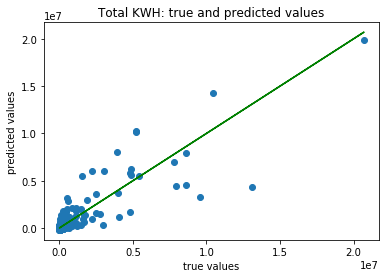

Mean absolute error of the prediction is: 141374.6586162148
Mean squared error of the prediction is: 187103307817.25204
Root mean squared error of the prediction is: 432554.39867981005
Mean absolute percentage error of the prediction is: 339.1943134492712


In [60]:
#make predictions of energy usage
Y = energy['TOTAL KWH']
X = energy[['DUMMIES BUILDING TYPE', 'AVERAGE STORIES', 'AVERAGE BUILDING AGE', 'AVERAGE HOUSESIZE', 'TOTAL THERMS', 'KWH TOTAL SQFT']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

X_test = sm.add_constant(X_test)

Y_preds = results.predict(X_test)

plt.scatter(Y_test, Y_preds)
plt.plot(Y_test, Y_test, color="green")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Total KWH: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, Y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds) / Y_test)) * 100))

In [116]:
#KNN regression 
from sklearn import neighbors

# Build model.
knn = neighbors.KNeighborsRegressor(n_neighbors=5, weights ='distance')
Y = energy['TOTAL KWH']
X = energy[['DUMMIES BUILDING TYPE', 'AVERAGE STORIES', 'AVERAGE BUILDING AGE', 'AVERAGE HOUSESIZE', 'TOTAL THERMS', 'KWH TOTAL SQFT']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

results = knn.fit(X_train, Y_train)
Y_preds = results.predict(X_test)

from sklearn.model_selection import cross_val_score
score = cross_val_score(knn, X, Y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))


print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, Y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, Y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, Y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - Y_preds) / Y_test)) * 100))

Accuracy: 0.58 (+/- 0.22)
Mean absolute error of the prediction is: 149835.06634242053
Mean squared error of the prediction is: 3005342463751.838
Root mean squared error of the prediction is: 1733592.3580103363
Mean absolute percentage error of the prediction is: 104.30239233278846


Comparing the two models, the adjusted R squared for the linear regression model is higher (0.697 to 0.58) than the KNN regression model and the prediction metrics are for the most part better. The mean absolute error, mean squared error and root mean squared error are all lower in the linear regression, but the mean absolute percentage error is lower for the KNN model. Overall, for predicting the energy usage I prefer the linear regression model because it takes into account all of the dataset whereas for any knn prediction it only takes the datapoints closest to it (in this case the 5 closest neighbors). In my opinion I think this makes the linear regression model in general more accurate and also less prone to overfitting. KNN seems to me to be better used in terms as a classifying model than as a regression.  